In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,scipy,pandas,matplotlib,seaborn

cs224 
last updated: 2020-05-02 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
scipy 1.4.1
pandas 1.0.2
matplotlib 3.1.3
seaborn 0.10.0


In [2]:
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import matplotlib as mpl

sns.set()

from IPython.display import display, HTML

display(HTML("<style>.container { width:70% !important; }</style>"))

import os,sys
sys.path.append(os.path.dirname(os.path.realpath('.')))

In [3]:
%load_ext autoreload
%autoreload 1
%aimport covid19

## Infection Dynamics: R-Value Estimation

* Paper: [Tracking R of COVID-19](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3581633)
    * [Real-Time Estimates of the Effective Reproduction Rate (R ) of COVID-19](http://trackingr-env.eba-9muars8y.us-east-2.elasticbeanstalk.com/)

$
\begin{eqnarray}
\hat R_t = R_0 \frac{S_t}{N} = 1 + \frac{1}{\gamma}\frac{I_t-I_{t-1}}{I_{t-1}}
\end{eqnarray}
$

Where $\gamma$ is the transition rate from infectious to recovered. $\gamma^{-1}$ is the serial interval in the SIR model and also equal to the average infectious period. In the paper the authors assume that people are infectious for $\gamma^{-1} = 7$ days.

$I_t$ are the number of people who are able to infect other people. In the paper they basically calculate $I_t$ as the number of infected minus the recovered minus the dead. This is on the one hand difficult, because the number of recovered people is not well known. On the other hand I also don't think that this approach is faithful to the model. The papers that lead to the estimate of $\gamma^{-1} = 7$ argue that people are only infectious for roughly (give-and-take) 7 days. Therefore I basically calculate $I_t$ as `df['new_confirmed'].rolling(window=7).sum()`, as the number of the persons confirmed to have the disease in the last 7 days.

You can then use several smoothing techniques for either $I_t$ or for $\frac{I_t-I_{t-1}}{I_{t-1}}$ or for $\ln\frac{I_t}{I_{t-1}}$ to make up for the noisy measurements of $I_t$. 

* Kalman smoothing: In the paper they use Kalman smoothing (see [How a Kalman filter works, in pictures](http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/)) via the `local level` model: `statsmodels.tsa.UnobservedComponents(lds, 'local level')` (see [documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html) for more details).
* I tried to used a [Gaussian Processes](http://www.gaussianprocess.org/gpml/) and
* the curve fit from the infection dynamics.

More information on how to calculate R can be found here:

* [Corona-Pandemie: Die Mathematik hinter den Reproduktionszahlen R](https://www.heise.de/newsticker/meldung/Corona-Pandemie-Die-Mathematik-hinter-den-Reproduktionszahlen-R-4712676.html)
    * [Nowcasting](https://corona.stat.uni-muenchen.de/nowcast/)
    
Especially the "nowcasting" may help to improve the current estimate.

In [4]:
df = covid19.get_rki_df()
df = df[df.index < pd.to_datetime('2020-05-02')]
cbr_germany = covid19.CasesByRegion('Germany', df=df)
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-27,158872,128930,5842,909,0,106
2020-04-28,159732,128930,6054,860,0,212
2020-04-29,160584,128930,6256,852,0,202
2020-04-30,161370,128930,6400,786,0,144
2020-05-01,161653,128930,6736,283,0,336


In [5]:
cbr_germany.fit(first_date=pd.to_datetime('2020-03-09'))
cbr_germany.calculate_R_estimates()
cbr_germany.R().round(3)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-04-29,0.616,0.479,0.292,0.386,0.494


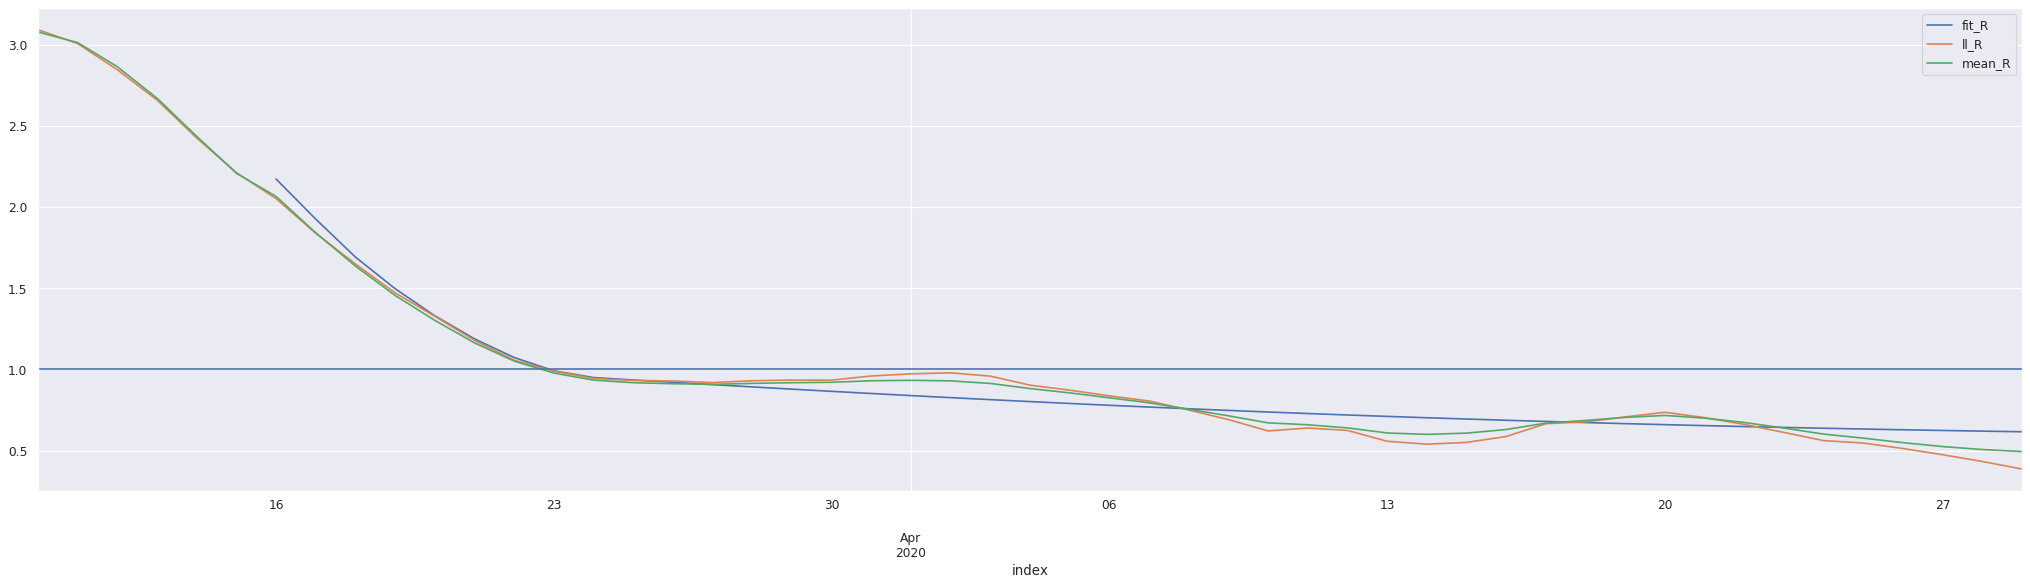

In [6]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_R(ax=ax, plot_start_date='2020-03-10')